# CAM-TensorFlow

We will use the Keras API of TensorFlow 2.0 to implement CAM.

### Import Labraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

### Load Inception V3

Before using CAM we need to check that the model has to have a global average pooling layer following a fully-connected layer as its output layer. Not all model satisfies these setup, so we need to modify our model and re-train it before using CAM.

Luckly, there is already a model called Inception v3 that exactly has a global average pooling layer and a fully-connected layer at its tail. So we can directly use Inception v3 for demonstration without modification and re-training.

![](../inceptionv3.png)

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

/Users/william/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=True)

In [4]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
_______________________________________________________________________________________

__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 17, 17, 192)  172032      activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 17, 17, 192)  172032      activation_37[0][0]              
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 17, 17, 192)  147456      average_pooling2d_3[0][0]        
__________

From the output of `inceptionv3.summary()` we can see that the last fully-connected layer is called `predictions`, and the layer before the global average pooling layer is called `mixed10`.

We will need the feature maps in the `mixed10` layer and the weights of the `predictions` layer.

### Implement CAM

![](../cam.png)

In [5]:
def load_image(img_path):
    img = Image.open(img_path)
    img = img.convert(mode='RGB')
    img = img.resize((299, 299))
    img = np.array(img)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    return img

In [6]:
def preprocess_img(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return img

In [7]:
def cam(img, model, feature_layer, fc_layer, top=1):
    img = preprocess_img(img)
    
    feature_model = Model(inputs=model.input, outputs=model.get_layer(feature_layer).output)
    weight, bias = model.get_layer(fc_layer).get_weights()
    
    pred = model.predict(img)  # (1, 1000)
    features = feature_model.predict(img)  # (1, 8, 8, 2048)
    
    class_index = pred.argsort().squeeze()  # (1000,)
    class_index = class_index[-top:]  # (top,)
    
    weight_c = weight[:, class_index]  # (2048, top)
    weight_c = weight_c.reshape((1, 1, -1, top))  # (1, 1, 2048, top)
    features = features.squeeze()  # (8, 8, 2048)
    features = np.expand_dims(features, axis=-1)  # (8, 8, 2048, 1)
    
    cams = np.sum(weight_c * features, axis=2)  # (8, 8, top)
    cams = [Image.fromarray(cams[:, :, i]) for i in range(top)]
    cams = [c.resize((299, 299), Image.ANTIALIAS) for c in cams]
    cams = [np.array(c) for c in cams]
    
    decode = decode_predictions(pred, top)[0]
    names = [d[1] for d in decode]
    probas = [d[2] for d in decode]
    
    return [(name, proba, cam) for name, proba, cam in zip(names, probas, cams)]

In [8]:
def plot_cam(img, name_proba_cam):
    cols = len(name_proba_cam) + 1
    
    plt.figure(figsize=(12, 12 * cols))
    
    for i in range(cols):
        if i == 0:
            plt.subplot(1, cols, i+1)
            plt.imshow(img, alpha=1.0)
            plt.title('Original image')
        else:
            name, proba, heatmap = name_proba_cam[i-1]
            plt.subplot(1, cols, i+1)
            plt.imshow(img, alpha=1.0)
            plt.imshow(heatmap, cmap='rainbow', alpha=0.7)
            plt.title('{} ({:.3f})'.format(name, proba))
        plt.axis('off');

### Results

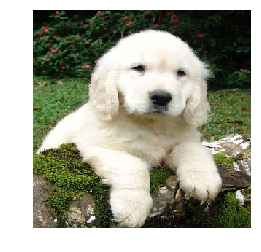

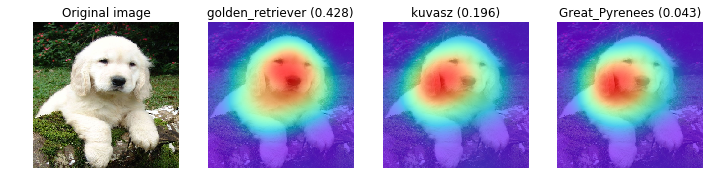

In [9]:
img = load_image('dog1.png')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

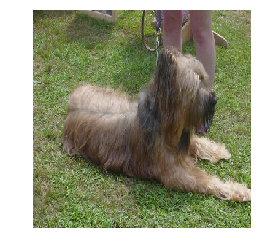

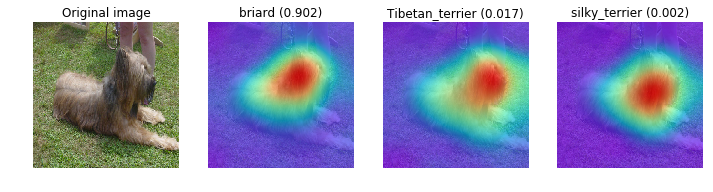

In [10]:
img = load_image('dog2.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

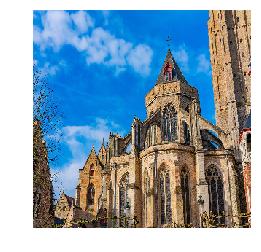

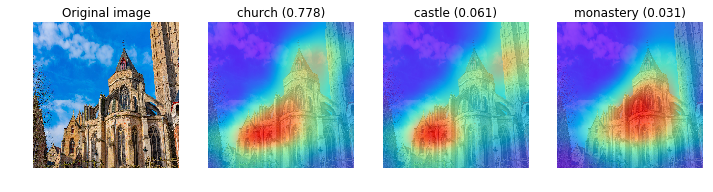

In [11]:
img = load_image('church.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

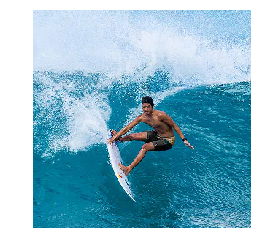

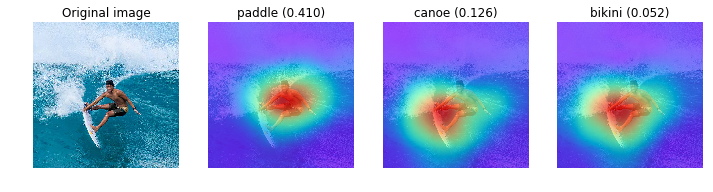

In [12]:
img = load_image('surfing.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

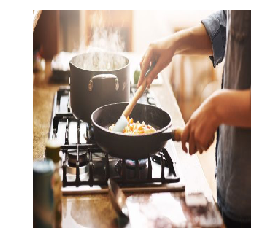

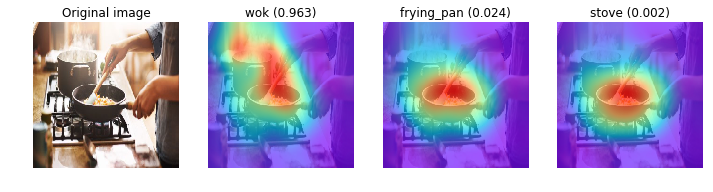

In [13]:
img = load_image('cooking.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

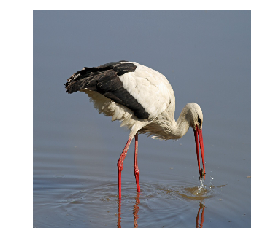

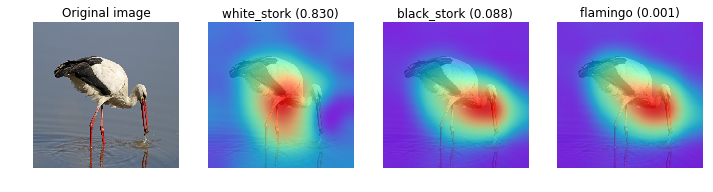

In [14]:
img = load_image('white stork.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)

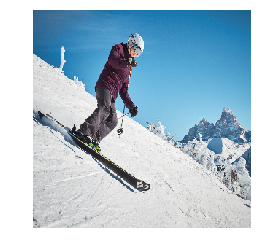

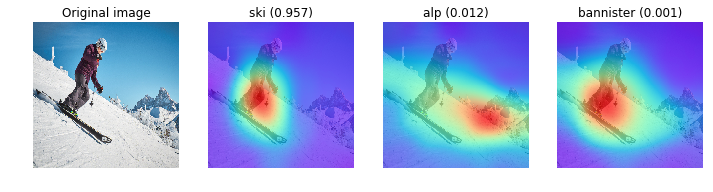

In [15]:
img = load_image('ski.jpg')
name_proba_cam = cam(img, inceptionv3, feature_layer='mixed10', fc_layer='predictions', top=3)
plot_cam(img, name_proba_cam)